In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *
from PIL import Image

#Para rodar no meu pc a VM Instance
#gcloud compute ssh jupyter@my-fastai-instance -- -L 8080:localhost:8080

# Testar to_fp16, size diferente, ir fazendo transfer learning de sizes diferentes, fine_tunning

# DATA

### Dataset

In [3]:
path = './UNIMIB2016'
path_anno = path + '/groundtruth_2'
path_img = path + '/original'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}GT.png'

In [4]:
np.random.seed(2) #mesma semente para todas as vezes que executar

fnames = get_image_files(path_img)
fnames[:3]

lbl_names = get_image_files(path_anno)
lbl_names[:3]

[PosixPath('UNIMIB2016/groundtruth_2/20151211_130638GT.png'),
 PosixPath('UNIMIB2016/groundtruth_2/20151204_131326GT.png'),
 PosixPath('UNIMIB2016/groundtruth_2/20151211_130826GT.png')]

In [5]:
# from PIL import Image
# # img  = Image.open(fnames[1])
# # width, height = img.size
# # img = img.resize((width//8, height//8)) 
# # img.show()
# for file in fnames:
#     image = Image.open(file)
#     image = image.resize((816, 612))
#     image.save(file)

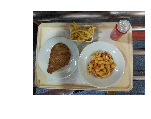

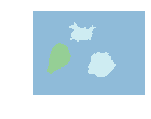

In [6]:

img = open_image(fnames[220])
img.show(figsize=(2,2))

img1 = open_mask(get_y_fn(fnames[220]))
img1.show(figsize=(2,2))

In [5]:
codes = np.loadtxt(path + '/' + 'codigos.txt', dtype=str); codes

array(['void', 'arancia', 'arrosto', 'arrosto_di_vitello', ..., 'torta_salata_spinaci_e_ricotta', 'yogurt',
       'zucchine_impanate', 'zucchine_umido'], dtype='<U39')

In [8]:
src_size = np.array(img.shape[1:]); 
print(src_size)
src_size = np.array(img1.shape[1:]); 
print(src_size)
print(src_size//1.75)

[612 816]
[612 816]
[349. 466.]


In [6]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs = 4 # batch size
size = np.array([350, 466])
print(size)

[350 466]


### Transformations

In [24]:
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(flip_vert=True)

### DataBunch

In [28]:
data = (SegmentationItemList.from_folder(path_img) #Where to find the data? -> in path and its subfolders
        #.split_by_rand_pct()
        .split_by_fname_file('../validation.txt')  #How to split in train/valid? -> use the folders
        .label_from_func(get_y_fn, classes=codes) #How to label? -> depending on the folder of the filenames
        #.add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=size, tfm_y=True)     #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [30]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(array(['void', 'arancia', 'arrosto', 'arrosto_di_vitello', ..., 'torta_salata_spinaci_e_ricotta', 'yogurt',
        'zucchine_impanate', 'zucchine_umido'], dtype='<U39'), 74, 667, 360)

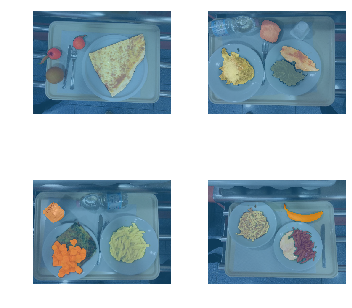

In [13]:
data.show_batch(2, figsize=(5,5), ds_type=DatasetType.Valid)

# TRAINING 

In [10]:
name2id = {v:k for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id
void_code = name2id['void']

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

dice_segmentation = partial(dice, iou=True)

In [15]:
wd=1e-4
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice_segmentation], wd=wd, callback_fns=ShowGraph).to_fp16()

In [32]:
learn.model[0].load_state_dict(torch.load(path + '/resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05


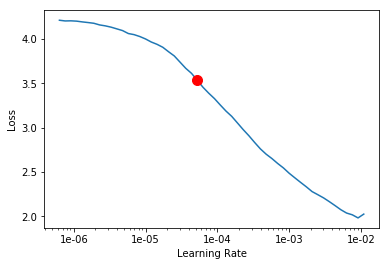

In [33]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [17]:
lr = 1e-4 # loss 3.5 para wd 1e-4
lr = 1e-4 # loss 4.5 para wd 1e-3
lr = 1e-4 # loss 5.5 para wd 1e-2

epoch,train_loss,valid_loss,acc_segmentation,dice,time
0,1.031980,0.714738,0.007016,-1.092333,02:16
1,0.633427,0.530508,0.157171,-1.095740,02:19
2,0.511706,0.428259,0.276183,-1.079231,02:20
3,0.420513,0.349005,0.384430,-1.065006,02:19
4,0.350272,0.283632,0.490349,-1.059588,02:19
5,0.323505,0.258047,0.536221,-1.056672,02:19
6,0.292077,0.235226,0.572359,-1.054966,02:19
7,0.271792,0.238105,0.598997,-1.053841,02:19
8,0.236256,0.201690,0.660805,-1.053805,02:19
9,0.182617,0.159538,0.727939,-1.052622,02:19


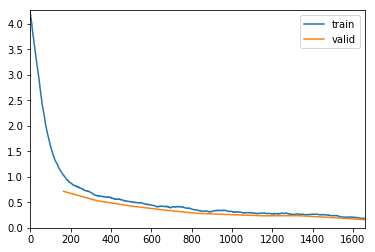

Better model found at epoch 0 with acc_segmentation value: 0.007016077172011137.
Better model found at epoch 1 with acc_segmentation value: 0.1571713089942932.
Better model found at epoch 2 with acc_segmentation value: 0.27618321776390076.
Better model found at epoch 3 with acc_segmentation value: 0.384429931640625.
Better model found at epoch 4 with acc_segmentation value: 0.49034878611564636.
Better model found at epoch 5 with acc_segmentation value: 0.5362207293510437.
Better model found at epoch 6 with acc_segmentation value: 0.5723594427108765.
Better model found at epoch 7 with acc_segmentation value: 0.598997175693512.
Better model found at epoch 8 with acc_segmentation value: 0.6608045697212219.
Better model found at epoch 9 with acc_segmentation value: 0.7279390692710876.


In [35]:
learn.fit_one_cycle(10, lr, pct_start=0.9,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='acc_segmentation',
                                                 name='stage-1-best')])

epoch,train_loss,valid_loss,acc_segmentation,dice,time
0,0.155828,0.152670,0.740897,-1.052401,02:15
1,0.157578,0.155412,0.746891,-1.052413,02:18
2,0.157054,0.147375,0.740578,-1.052386,02:19
3,0.150928,0.158980,0.732721,-1.053147,02:19
4,0.162439,0.148454,0.756137,-1.052796,02:19
5,0.163129,0.146523,0.748873,-1.053233,02:19
6,0.174446,0.153876,0.722735,-1.053084,02:19
7,0.170769,0.155272,0.732752,-1.052394,02:19
8,0.152377,0.151422,0.752272,-1.052846,02:19
9,0.127704,0.122831,0.801679,-1.051630,02:19


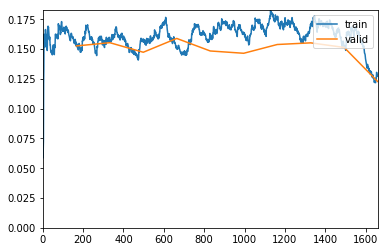

Better model found at epoch 0 with acc_segmentation value: 0.7408972978591919.
Better model found at epoch 1 with acc_segmentation value: 0.7468906044960022.
Better model found at epoch 4 with acc_segmentation value: 0.7561371922492981.
Better model found at epoch 9 with acc_segmentation value: 0.8016790747642517.


In [37]:
learn.load('stage-1-best')
learn.fit_one_cycle(10, lr, pct_start=0.9,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='acc_segmentation',
                                                 name='stage-1-best')])

epoch,train_loss,valid_loss,acc_segmentation,dice,time
0,0.103843,0.114333,0.818306,-1.051535,02:15
1,0.108045,0.119339,0.810362,-1.051422,02:19
2,0.109247,0.110569,0.819761,-1.051785,02:19
3,0.108436,0.115629,0.808069,-1.051685,02:19
4,0.110551,0.127801,0.782918,-1.051689,02:19
5,0.130713,0.135175,0.785759,-1.052009,02:19
6,0.137959,0.141038,0.760047,-1.052250,02:19
7,0.134126,0.116623,0.785305,-1.052307,02:19
8,0.135842,0.136235,0.770490,-1.052153,02:19
9,0.093777,0.108234,0.831145,-1.051285,02:19


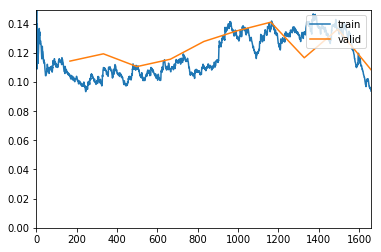

Better model found at epoch 0 with acc_segmentation value: 0.8183055520057678.
Better model found at epoch 2 with acc_segmentation value: 0.8197607398033142.
Better model found at epoch 9 with acc_segmentation value: 0.8311449885368347.


In [39]:
learn.load('stage-1-best')
learn.fit_one_cycle(10, lr, pct_start=0.9, wd=1e-2, #aumentei a regularizacao
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='acc_segmentation',
                                                 name='stage-1-best')])

epoch,train_loss,valid_loss,acc_segmentation,dice,time
0,0.080110,0.099716,0.849358,-1.051132,02:15
1,0.080218,0.099970,0.854045,-1.051127,02:18
2,0.075652,0.099295,0.854372,-1.050978,02:19
3,0.083984,0.099549,0.858430,-1.051295,02:19
4,0.076500,0.101462,0.845604,-1.051210,02:19
5,0.088944,0.108138,0.821918,-1.051626,02:19
6,0.079983,0.105552,0.842686,-1.051227,02:19
7,0.083974,0.118754,0.813167,-1.051288,02:19
8,0.087138,0.105785,0.842433,-1.051168,02:19
9,0.097233,0.116110,0.807354,-1.051451,02:19


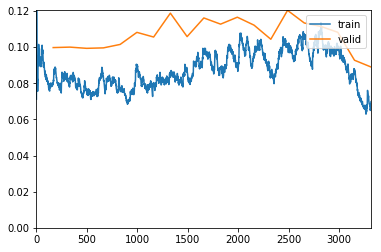

Better model found at epoch 0 with acc_segmentation value: 0.8493576049804688.
Better model found at epoch 1 with acc_segmentation value: 0.8540452122688293.
Better model found at epoch 2 with acc_segmentation value: 0.8543715476989746.
Better model found at epoch 3 with acc_segmentation value: 0.8584302067756653.
Better model found at epoch 18 with acc_segmentation value: 0.8615132570266724.
Better model found at epoch 19 with acc_segmentation value: 0.8700870275497437.


In [41]:
learn.load('stage-1-best')
learn.fit_one_cycle(20, lr, pct_start=0.9, wd=1e-2, #aumentei a regularizacao
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='acc_segmentation',
                                                 name='stage-1-best')])

In [42]:
# learn.load('stage-1-best')
# learn.save('stage-1-size350-466-bestEpoch-accSemVoid',return_path=True)

PosixPath('UNIMIB2016/original/models/stage-1-size350-466-bestEpoch-accSemVoid.pth')

In [ ]:
learn.show_results(figsize=(15,15))

# INTERPRETATION

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice], wd=wd)
#learn.load('stage-1-size7-8epochs')
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
#interp.plot_top_losses(9, figsize=(15,11))


In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=10)

# FINE-TUNING

In [65]:
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice_segmentation], wd=wd, callback_fns=ShowGraph).to_fp16()
learn.load('stage-1-size350-466-bestEpoch-accSemVoid')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


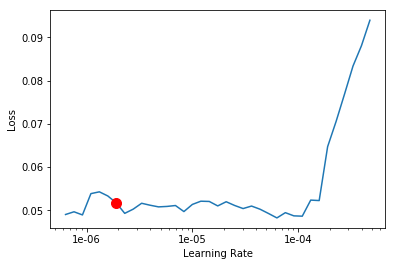

In [66]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [67]:
# loss sempre crescente para wd 1e-4.
# loss 0.065 para wd 1e-3. Começa aumentar em lr = 1e-4
# loss 0.06 para wd 1e-2. Começa aumentar em lr = 1e-4
lrs = slice(lr/400,lr/4)

epoch,train_loss,valid_loss,acc_segmentation,dice,time
0,0.055823,0.088326,0.870318,-1.050869,02:23
1,0.055076,0.088943,0.872722,-1.050779,02:25
2,0.052620,0.088882,0.872521,-1.050736,02:26
3,0.053718,0.087928,0.872999,-1.050743,02:26
4,0.054256,0.087835,0.874846,-1.050701,02:26
5,0.051838,0.090770,0.870112,-1.050739,02:26
6,0.052468,0.091641,0.872274,-1.050708,02:26
7,0.056374,0.090669,0.874447,-1.050719,02:26
8,0.050532,0.089318,0.870703,-1.050702,02:26
9,0.054909,0.090800,0.871110,-1.050721,02:25


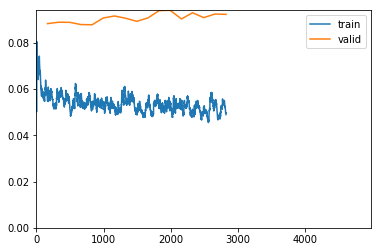

Better model found at epoch 0 with acc_segmentation value: 0.8703177571296692.
Better model found at epoch 1 with acc_segmentation value: 0.8727218508720398.
Better model found at epoch 3 with acc_segmentation value: 0.8729986548423767.
Better model found at epoch 4 with acc_segmentation value: 0.8748462200164795.
Better model found at epoch 14 with acc_segmentation value: 0.8805505633354187.


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  

KeyboardInterrupt: 

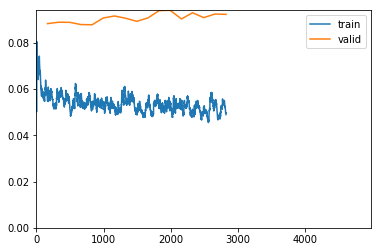

In [68]:
learn.fit_one_cycle(30, lrs, pct_start=0.8, 
callbacks=[SaveModelCallback(learn, every='improvement', monitor='acc_segmentation',
                                                 name='stage-2-best')])

In [61]:
# NAO SALVOU STAGE 2 POIS DEU OVERFITTING. PARAMETROS  DA CNN JA ESTAO BONS POIS VIERAM DO FOOD101
# learn.load('stage-2-best')
# learn.save('stage-2-size350-466-bestEpoch-accSemVoid')

# POSPROCESSING

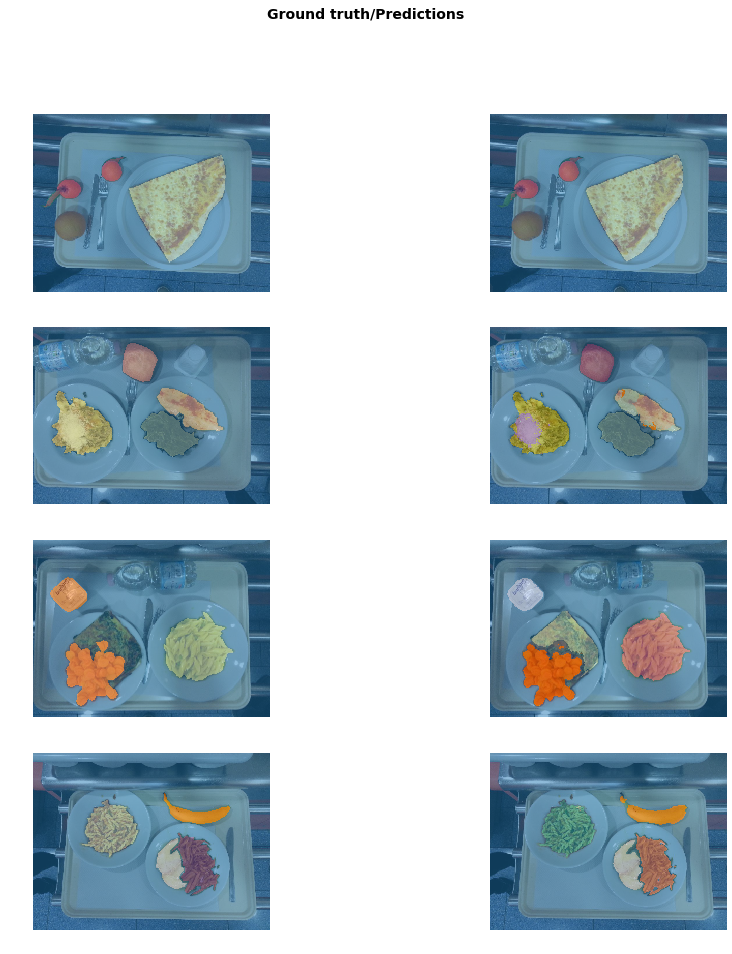

In [11]:
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice_segmentation])
learn.load('stage-1-size350-466-bestEpoch-accSemVoid') #melhor modelo foi sem unfreeze!
learn.show_results(figsize=(10,10))

In [12]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id
preds = learn.get_preds(ds_type=DatasetType.Valid)

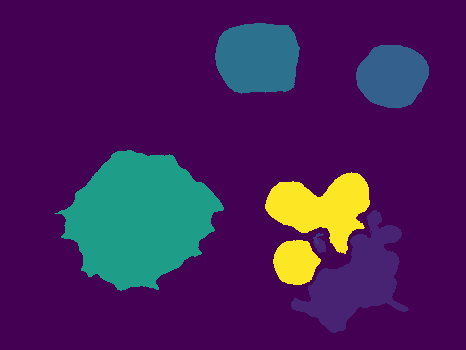

In [13]:
index = 10
pred = learn.predict(data.valid_ds.x[index])
pred[0]

In [14]:
predArray = pred[0].data.numpy() #imagem com os labels de cada pixel
predArray = np.squeeze(predArray,axis=0)
foods, counts = np.unique(predArray,return_counts=True)
counts = np.delete(counts, 0) #tira o void na posicao 0 do array
foods = np.delete(foods, 0) #tira o void na posicao 0 do array
foodNames = []
print(f'Numero de alimentos: {len(foods)}')
for food in foods:
    foodNames = np.append(foodNames,id2name[food])
print(dict(zip(foodNames, counts)))

Numero de alimentos: 7
{'carote': 6302, 'crema_zucca_e_fagioli': 48, 'mele': 3565, 'pane': 5044, 'pasta_sugo_vegetariano': 1, 'pasta_tonno': 15096, 'zucchine_impanate': 6364}


./UNIMIB2016/groundtruth_2/20151203_125246GT.png
Numero de alimentos: 5
{'carote': 6645, 'mele': 3612, 'pane': 5079, 'pasta_tonno': 15024, 'zucchine_impanate': 6374}


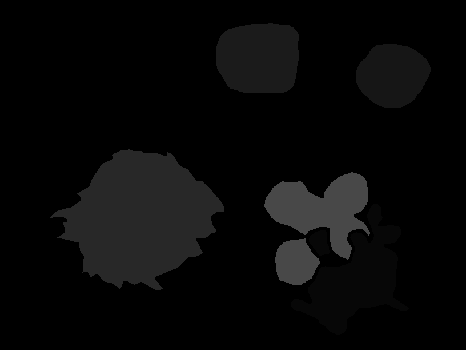

In [15]:
print(data.valid_ds.y.items[index])
imgTarget = Image.open(data.valid_ds.y.items[index])
img = imgTarget.resize(np.flip(size))
targArray = np.array(img)
foods, counts = np.unique(targArray,return_counts=True)
counts = np.delete(counts, 0) #tira o void na posicao 0 do array
foods = np.delete(foods, 0) #tira o void na posicao 0 do array
foodNames = []
print(f'Numero de alimentos: {len(foods)}')
for food in foods:
    foodNames = np.append(foodNames,id2name[food])
print(dict(zip(foodNames, counts)))
img

In [16]:
target = preds[1][index].data.numpy()
foods, counts = np.unique(target,return_counts=True)
counts = np.delete(counts, 0) #tira o void na posicao 0 do array
foods = np.delete(foods, 0) #tira o void na posicao 0 do array
accuracy = (target == predArray).mean()
print(accuracy)

0.986241569589209


# PREDICTIONS

In [ ]:
data = 
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice_segmentation])
learn.load('stage-1-size350-466-bestEpoch-accSemVoid') #melhor modelo foi sem unfreeze!
img = data.train_ds[0][0]
learn.predict(img);
img.show(y=learn.predict(img)[0])